## FDR control of the integrative conformal p-values with conditional calibration
This notebook shows the usage of the conditional calibration method detailed in the accompanying paper, it is shown that conditional calibration method is able to theoretically control the FDR with finite sample and this notebook confirms empirically with some synthetic datasets. Furthermore, we also implemented BH procedure to the integrative conformal p-values, which can also control FDR empirically while lack theoretical support.

In [25]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy

import sys
import os

from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


sys.path.append('../methods')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define experiment parameters

In [26]:
#########################
# Experiment parameters #
#########################
data_name = "circles-mixed" 
n = 1000      # number of training/calibration data
p = 100      # number of features
a = 2        # signal strength
purity = 0.5  # purity of the train/calibration data
alpha = 0.1   # pre-specified FDR level
n_test = 20   # number of test points
random_state = 2022

# Fixed experiment parameters
purity_test = 0.5
calib_size = 0.5
num_repetitions = 20
J_max = 10

In [27]:
# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [svm.OneClassSVM(kernel='rbf', gamma="auto"),
                 svm.OneClassSVM(kernel='sigmoid'),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = 'auto', random_state=random_state),
                 LocalOutlierFactor(contamination='auto', novelty=True)
               ]

# Define list of possible two-class classifiers with desired hyper-parameters
bbox_bc_list = [RandomForestClassifier(random_state=random_state),
                KNeighborsClassifier(),
                SVC(probability=True),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),   
                MLPClassifier(max_iter=500, random_state=random_state) 
               ]

## Define the experiment

In [28]:
from models import ConcentricCircles, ConcentricCirclesMixture, BinomialModel

# data generating models
class DataSet:
    def __init__(self, data_name, random_state=None):
        if data_name=="circles":
            self.model = ConcentricCircles(p, a, random_state=random_state)
        elif data_name=="circles-mixed":
            self.model = ConcentricCirclesMixture(p, a, random_state=random_state)
        elif data_name=="binomial":
            self.model = BinomialModel(p, a, random_state=random_state)
        else:
            print("Error: unknown model name!")
            exit(0)

    def sample(self, n, purity, random_state=None):
        return self.model.sample(n, purity, random_state=random_state)

In [29]:
# evaluate the power and fdr of a rejection set
def eval_discoveries(reject, Y):
    is_nonnull = (Y==1)
    rejections = np.sum(reject)
    if rejections>0:
        fdp = 1-np.mean(is_nonnull[np.where(reject)[0]])
        power = np.sum(is_nonnull[np.where(reject)[0]]) / np.sum(is_nonnull)
    else:
        fdp = 0
        power = 0
    return fdp, power

In [30]:
from tabnanny import verbose
from methods_split import IntegrativeConformal
from methods_fdr import IntegrativeConformalFDR

def run_experiment(dataset, random_state):
    # Sample the training/calibration data
    X, Y = dataset.sample(n, purity)
    X_in = X[Y==0]
    X_out = X[Y==1]
    # Sample the test data
    X_test, Y_test = dataset.sample(n_test, purity_test)

    # Initialize result data frame
    results = pd.DataFrame({})

    ## Conformal p-values via weighted one-class classification and learning ensemble
    print("Running weighted classifiers with learning ensemble...")
    sys.stdout.flush()
    bboxes_one = copy.deepcopy(bbox_occ_list)
    bboxes_two = copy.deepcopy(bbox_bc_list)
    method = IntegrativeConformal(X_in, X_out,
                                  bboxes_one=bboxes_one, bboxes_two=bboxes_two,
                                  calib_size=calib_size, tuning=True, progress=False, verbose=False)

    icfdr = IntegrativeConformalFDR(method)

    # Apply the new method with no loo
    reject_sel, pruned_sel = icfdr.filter_fdr_conditional(X_test, alpha, J_max=J_max, loo='none', verbose=False)
    fdp_sel, power_sel = eval_discoveries(reject_sel, Y_test)    
    results_tmp = pd.DataFrame({"Method":["Selective"], "FDP":[fdp_sel], "Power":[power_sel], "LOO":['none'], "Pruned":[pruned_sel]})
    results = pd.concat([results, results_tmp])

    # Apply the regular BH
    reject_bh = icfdr.filter_fdr_bh(X_test, alpha)
    fdp_bh, power_bh = eval_discoveries(reject_bh, Y_test)
    results_tmp = pd.DataFrame({"Method":["BH"], "FDP":[fdp_bh], "Power":[power_bh], "LOO":["none"], "Pruned":[False]})
    results = pd.concat([results, results_tmp])

    return results

In [ ]:
# Initialize result data frame
results = pd.DataFrame({})

for r in range(num_repetitions):
    print("\nStarting repetition {:d} of {:d}:\n".format(r+1, num_repetitions))
    sys.stdout.flush()
    # Change random seed for this repetition
    random_state_new = 10*num_repetitions*random_state + r
    dataset = DataSet(data_name, random_state=random_state_new)
    # Run experiment and collect results
    results_new = run_experiment(dataset, random_state_new)
    results_new["Repetition"] = r
    results = pd.concat([results, results_new])

## Plot the FDR and Power of BH and conditional calibration

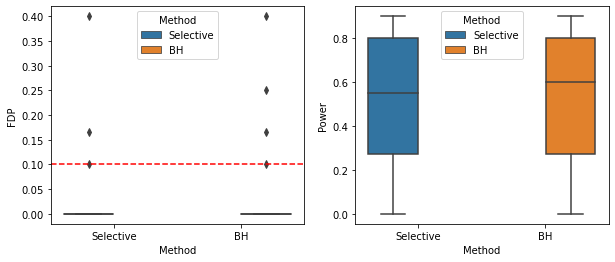

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="FDP", x="Method", hue="Method", data=results, ax=ax1)
ax1.set(xlabel='Method', ylabel='FDP')
ax1.axhline(alpha, ls='--', color="red")
ax1.legend(loc='upper center', title='Method')

sns.boxplot(y="Power", x="Method", hue="Method", data=results, ax=ax2)
ax2.set(xlabel='Method', ylabel='Power')
ax2.legend(loc='upper center', title='Method')
plt.show()